In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('/root/prac/task2/content/training.csv')
data.head()

,Date,Value
0,1959-01-01,22.8331
1,1959-02-01,23.2802
2,1959-03-01,23.6156
3,1959-04-01,24.1186
4,1959-05-01,24.4820


## График исходного ряда и скользящих статистик

Построим график исходного ряда и скользящих статистик (среднее, стандартное отклонение)

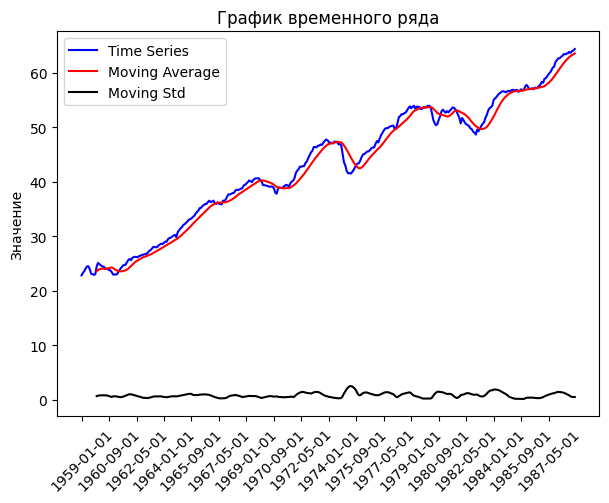

In [3]:
plt.figure(figsize=(7, 5))
data['Value'].plot(color='blue', label='Time Series')
data['Value'].rolling(window=12, center=False).mean().plot(color='red', label='Moving Average')
data['Value'].rolling(window=12, center=False).std().plot(color='black', label = 'Moving Std')
plt.title('График временного ряда')
plt.ylabel('Значение')
plt.legend()
plt.xticks(ticks=np.arange(0, len(data['Date']), 20), 
           labels=data['Date'][::20], rotation=45)
plt.show()

## Тест Дики-Фуллера

Рассмотрим уровень значимости α = 0.05

**Нулевая гипотеза** *H₀*: Ряд не является стационарным  

**Альтернативная гипотеза** *H₁*: Ряд является стационарным

Смотрим на значение `p_value`.  
Если `p_value < α`, то мы отвергаем нулевую гипотезу.  
Если же `p_value > α`, то не отвергаем.

Проведем тест Дики–Фуллера.


In [4]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data['Value'], autolag='AIC')
result = {
        'Test Statistic': result[0],
        'p-value': result[1],
        'Lags Used': result[2],
        'Number of Observations': result[3],
        'Critical Values': result[4],
        }
print("Results of Dickey-Fuller Test:")
for key, value in result.items():
    print(f"{key}: {value}")

Results of Dickey-Fuller Test:
Test Statistic: -0.2533911799284611
p-value: 0.9318510422993468
Lags Used: 5
Number of Observations: 354
Critical Values: {'1%': np.float64(-3.4489583388155194), '5%': np.float64(-2.869739378430086), '10%': np.float64(-2.5711381780459)}


*p_value* = 0.9318510422993468 ⇒ не отвергаем нулевую гипотезу. То есть у нас нет оснований полагать, что ряд является стационарным


## Аддитивная модель

Разложим временной ряд на тренд, сезональность, остаток в соответствии с аддитивной моделью

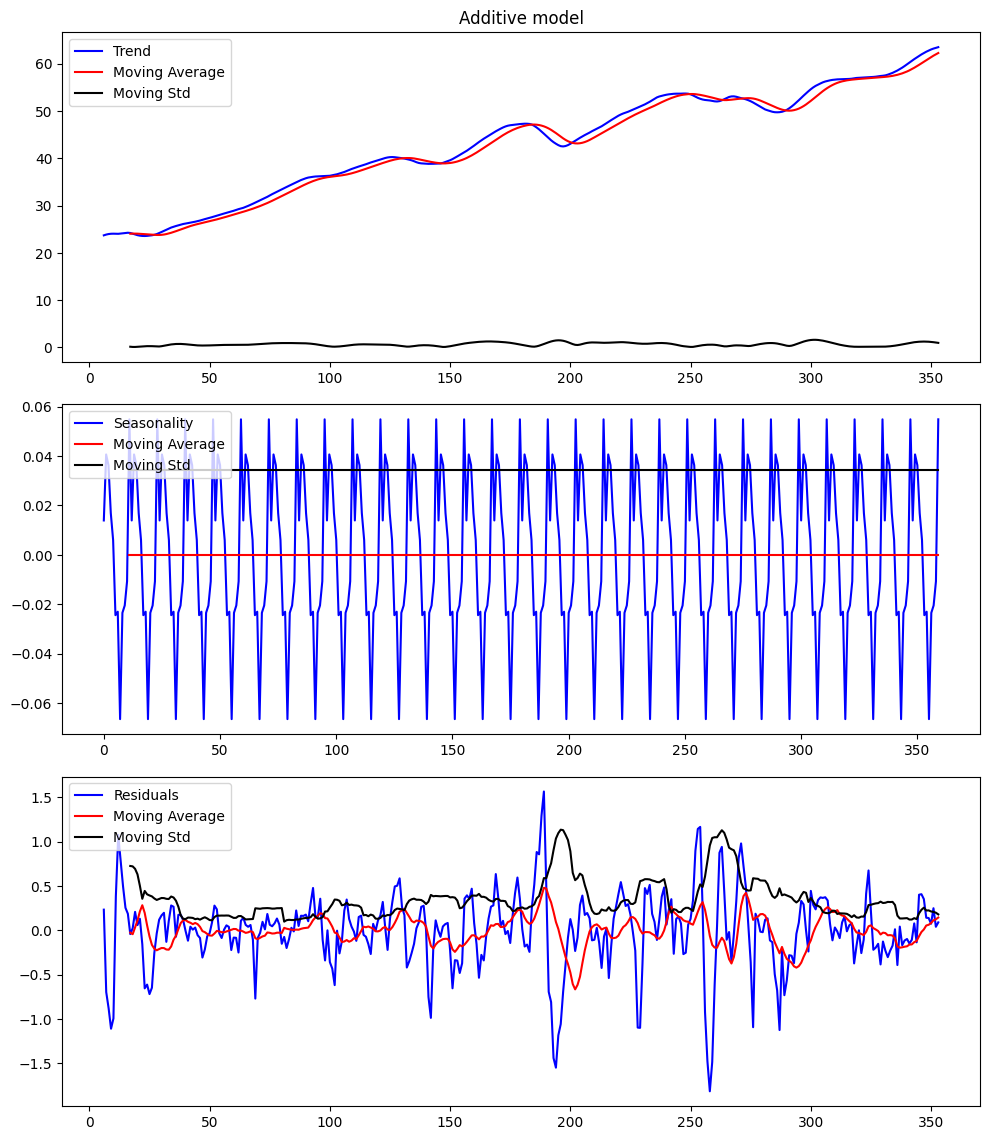

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose


decomposition = seasonal_decompose(data['Value'], model='additive', period=12)

# Получение компонентов
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Визуализация
plt.figure(figsize=(10, 15))


plt.subplot(412)
plt.title('Additive model')
trend.plot(color='blue', label='Trend')
trend.rolling(window=12, center=False).mean().plot(color='red', label='Moving Average')
trend.rolling(window=12, center=False).std().plot(color='black', label = 'Moving Std')
plt.legend(loc='upper left')

plt.subplot(413)
seasonal.plot(color='blue', label='Seasonality')
seasonal.rolling(window=12, center=False).mean().plot(color='red', label='Moving Average')
seasonal.rolling(window=12, center=False).std().plot(color='black', label = 'Moving Std')
plt.legend(loc='upper left')

plt.subplot(414)
residual.plot(color='blue', label='Residuals')
residual.rolling(window=12, center=False).mean().plot(color='red', label='Moving Average')
residual.rolling(window=12, center=False).std().plot(color='black', label = 'Moving Std')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

Проведем тесты Дики-Фуллера для каждого из рядов

In [6]:
result = adfuller(trend.dropna(), autolag='AIC')
result = {
        'Test Statistic': result[0],
        'p-value': result[1],
        'Lags Used': result[2],
        'Number of Observations': result[3],
        'Critical Values': result[4],
        }
print("Results of Dickey-Fuller Test:")
for key, value in result.items():
    print(f"{key}: {value}")

Results of Dickey-Fuller Test:
Test Statistic: -0.8615760333584023
p-value: 0.8003625761532233
Lags Used: 17
Number of Observations: 330
Critical Values: {'1%': np.float64(-3.4503224123605194), '5%': np.float64(-2.870338478726661), '10%': np.float64(-2.571457612488522)}


Не отвергаем нулевую гипотезу. Нет оснований полагать, что тренд является стационарным рядом

In [7]:
result = adfuller(seasonal.dropna(), autolag='AIC')
result = {
        'Test Statistic': result[0],
        'p-value': result[1],
        'Lags Used': result[2],
        'Number of Observations': result[3],
        'Critical Values': result[4],
        }
print("Results of Dickey-Fuller Test:")
for key, value in result.items():
    print(f"{key}: {value}")

Results of Dickey-Fuller Test:
Test Statistic: -540389567101099.7
p-value: 0.0
Lags Used: 11
Number of Observations: 348
Critical Values: {'1%': np.float64(-3.4492815848836296), '5%': np.float64(-2.8698813715275406), '10%': np.float64(-2.5712138845950587)}


Отвергаем нулевую гипотезу и делаем вывод, что сезональность является стационарным рядом

In [8]:
result = adfuller(residual.dropna(), autolag='AIC')
result = {
        'Test Statistic': result[0],
        'p-value': result[1],
        'Lags Used': result[2],
        'Number of Observations': result[3],
        'Critical Values': result[4],
        }
print("Results of Dickey-Fuller Test:")
for key, value in result.items():
    print(f"{key}: {value}")

Results of Dickey-Fuller Test:
Test Statistic: -7.485563833765426
p-value: 4.649096674694056e-11
Lags Used: 5
Number of Observations: 342
Critical Values: {'1%': np.float64(-3.4496162602188187), '5%': np.float64(-2.870028369720798), '10%': np.float64(-2.5712922615505627)}


Отвергаем нулевую гипотезу и делаем вывод, что остаток является стационарным рядом

## Мультипликативная модель

Разложим временной ряд на тренд, сезональность, остаток в соответствии с мультипликативной моделью

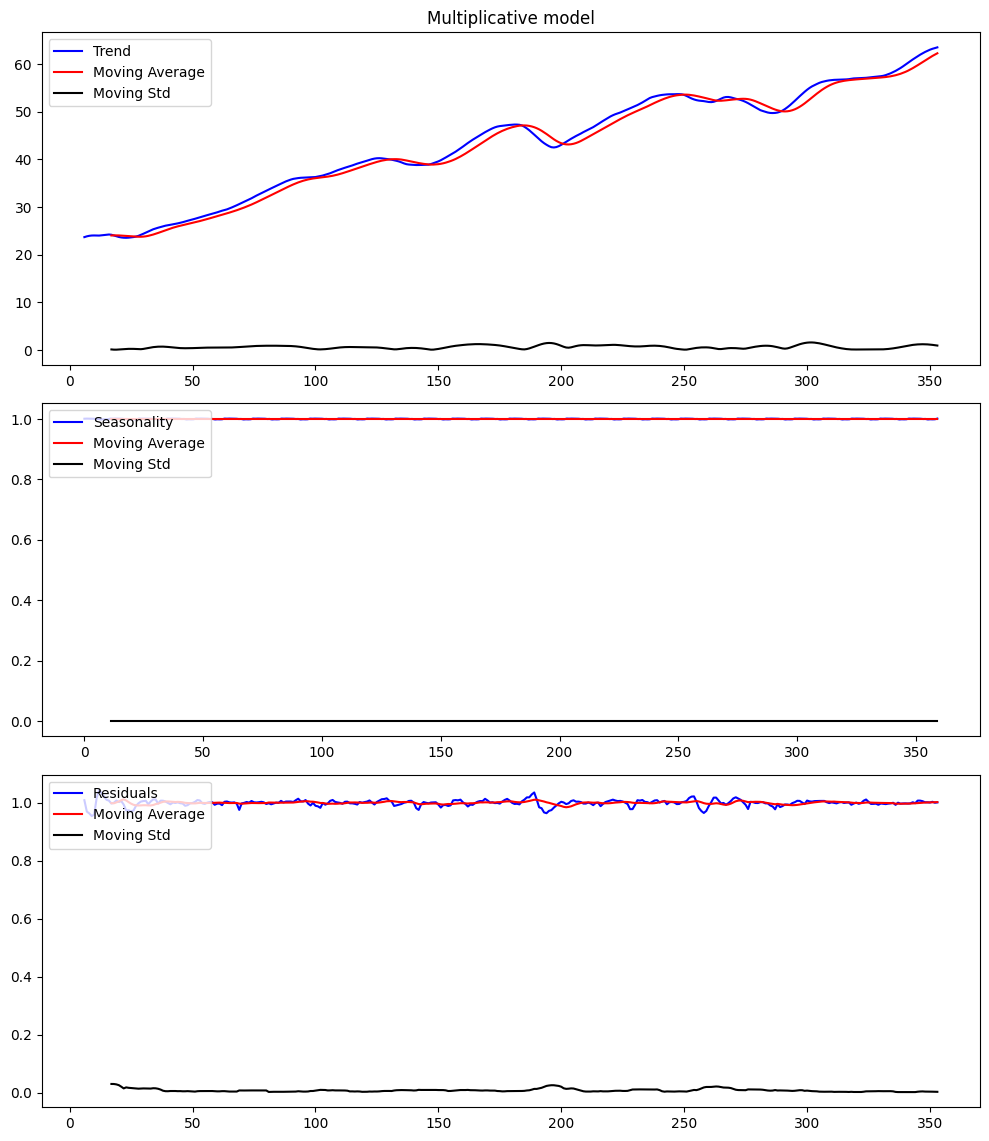

In [9]:
decomposition = seasonal_decompose(data['Value'], model='multiplicative', period=12)

# Получение компонентов
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Визуализация
plt.figure(figsize=(10, 15))


plt.subplot(412)
trend.plot(color='blue', label='Trend')
trend.rolling(window=12, center=False).mean().plot(color='red', label='Moving Average')
trend.rolling(window=12, center=False).std().plot(color='black', label = 'Moving Std')
plt.title('Multiplicative model')
plt.legend(loc='upper left')

plt.subplot(413)
seasonal.plot(color='blue', label='Seasonality')
seasonal.rolling(window=12, center=False).mean().plot(color='red', label='Moving Average')
seasonal.rolling(window=12, center=False).std().plot(color='black', label = 'Moving Std')
plt.legend(loc='upper left')

plt.subplot(414)
residual.plot(color='blue', label='Residuals')
residual.rolling(window=12, center=False).mean().plot(color='red', label='Moving Average')
residual.rolling(window=12, center=False).std().plot(color='black', label = 'Moving Std')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [10]:
result = adfuller(trend.dropna(), autolag='AIC')
result = {
        'Test Statistic': result[0],
        'p-value': result[1],
        'Lags Used': result[2],
        'Number of Observations': result[3],
        'Critical Values': result[4],
        }
print("Results of Dickey-Fuller Test:")
for key, value in result.items():
    print(f"{key}: {value}")

Results of Dickey-Fuller Test:
Test Statistic: -0.8615760333584023
p-value: 0.8003625761532233
Lags Used: 17
Number of Observations: 330
Critical Values: {'1%': np.float64(-3.4503224123605194), '5%': np.float64(-2.870338478726661), '10%': np.float64(-2.571457612488522)}


Не отвергаем нулевую гипотезу. Нет оснований полагать, что тренд является стационарным рядом

In [11]:
result = adfuller(seasonal.dropna(), autolag='AIC')
result = {
        'Test Statistic': result[0],
        'p-value': result[1],
        'Lags Used': result[2],
        'Number of Observations': result[3],
        'Critical Values': result[4],
        }
print("Results of Dickey-Fuller Test:")
for key, value in result.items():
    print(f"{key}: {value}")

Results of Dickey-Fuller Test:
Test Statistic: -39820684499748.516
p-value: 0.0
Lags Used: 17
Number of Observations: 342
Critical Values: {'1%': np.float64(-3.4496162602188187), '5%': np.float64(-2.870028369720798), '10%': np.float64(-2.5712922615505627)}


Отвергаем нулевую гипотезу и делаем вывод, что сезональность является стационарным рядом

In [12]:
result = adfuller(residual.dropna(), autolag='AIC')
result = {
        'Test Statistic': result[0],
        'p-value': result[1],
        'Lags Used': result[2],
        'Number of Observations': result[3],
        'Critical Values': result[4],
        }
print("Results of Dickey-Fuller Test:")
for key, value in result.items():
    print(f"{key}: {value}")

Results of Dickey-Fuller Test:
Test Statistic: -7.466083739785173
p-value: 5.200193898326747e-11
Lags Used: 5
Number of Observations: 342
Critical Values: {'1%': np.float64(-3.4496162602188187), '5%': np.float64(-2.870028369720798), '10%': np.float64(-2.5712922615505627)}


Отвергаем нулевую гипотезу и делаем вывод, что остаток является стационарным рядом

Вывод: в обеих моделях тренд не является стационарным рядом, сезональность и остаток являются стационарными рядами

## Интегрирование порядка *k*

Ряд является интегрированным порядка *k*, если разности *k*-го порядка от него являются стационарным рядом.

Преобразуем временной ряд с использованием натурального логарифма и вычислим разности первого порядка. Далее проведем тест Дики–Фуллера для разностей.


In [13]:
ts_log = np.log(data['Value'])
ts_log_diff = ts_log - ts_log.shift()
result = adfuller(ts_log_diff.dropna(), autolag='AIC')
result = {
        'Test Statistic': result[0],
        'p-value': result[1],
        'Lags Used': result[2],
        'Number of Observations': result[3],
        'Critical Values': result[4],
        }
print("Results of Dickey-Fuller Test:")
for key, value in result.items():
    print(f"{key}: {value}")

Results of Dickey-Fuller Test:
Test Statistic: -8.187894507566572
p-value: 7.809572497700592e-13
Lags Used: 4
Number of Observations: 354
Critical Values: {'1%': np.float64(-3.4489583388155194), '5%': np.float64(-2.869739378430086), '10%': np.float64(-2.5711381780459)}


Отвергаем нулевую гипотезу и делаем вывод, что ряд являются интегрированным  1-го порядка

Построим графики функций автокорреляции (*ACF*) и частичной автокорреляции (*PACF*)

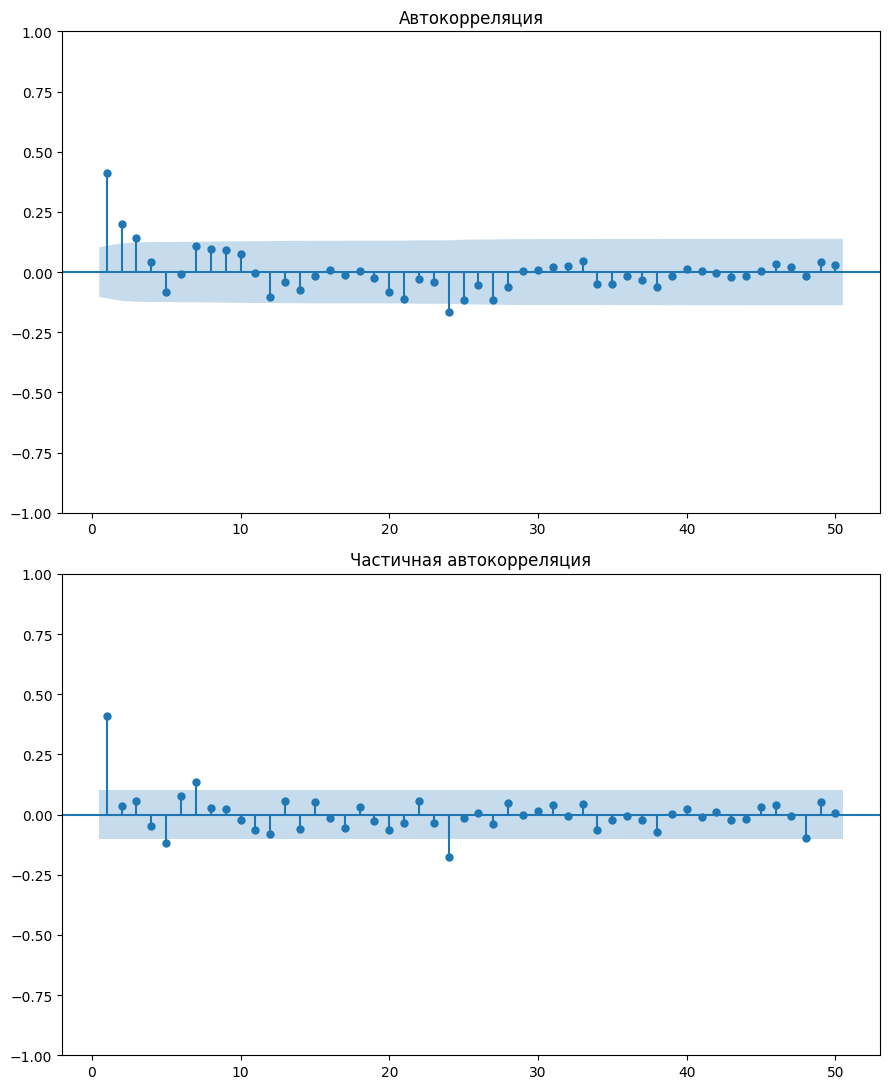

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(9, 11))
plt.subplot(211)
plot_acf(ts_log_diff.dropna(), lags=50, ax=plt.gca(), zero=False)
plt.title('Автокорреляция')

plt.subplot(212)
plot_pacf(ts_log_diff.dropna(), lags=50, ax=plt.gca(), zero=False)
plt.title('Частичная автокорреляция')

plt.tight_layout()
plt.show()

По *ACF* определяем порядок скользящего среднего *q*. По *PACF* определяем порядок авторегрессии *p*. Как определяем: смотрим на лаги, которые выходят за доверительный интервал

## *ARIMA(1,1,3)*

В качестве первой модели предложим модель скользящего среднего 3-го порядка и авторегрессии 1-го порядка *ARIMA(1,1,3)*

In [15]:
from statsmodels.tsa.arima.model import ARIMA

model_1 = ARIMA(ts_log, order=(1, 1, 3))
model_1_fit = model_1.fit()
print(model_1_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  360
Model:                 ARIMA(1, 1, 3)   Log Likelihood                1195.508
Date:                Fri, 21 Nov 2025   AIC                          -2381.016
Time:                        17:09:06   BIC                          -2361.599
Sample:                             0   HQIC                         -2373.295
                                - 360                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6483      0.164      3.943      0.000       0.326       0.971
ma.L1         -0.2194      0.150     -1.463      0.143      -0.513       0.075
ma.L2         -0.0509      0.081     -0.629      0.5

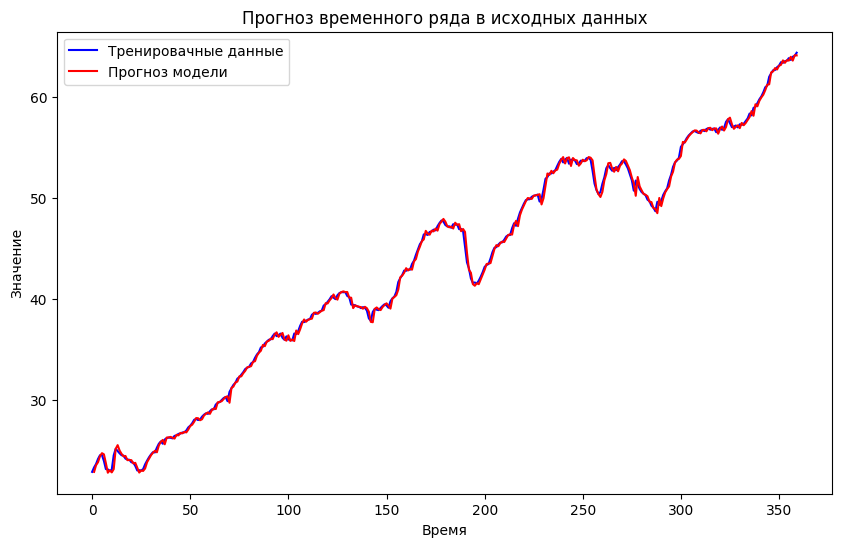

In [16]:
# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Value'], label='Тренировачные данные', color='blue')
plt.plot(data.index[1:], np.exp(model_1_fit.fittedvalues)[1:], label='Прогноз модели', color='red')
plt.legend()
plt.title('Прогноз временного ряда в исходных данных')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.show()

In [18]:
test_data = pd.read_csv('/root/prac/task2/content/testing.csv')
test_data.head()

,Date,Value
0,1989-01-01,64.6158
1,1989-02-01,64.3268
2,1989-03-01,64.4548
3,1989-04-01,64.5270
4,1989-05-01,64.0662


In [19]:
from sklearn.metrics import r2_score

forecast = model_1_fit.forecast(steps=len(test_data))

# Преобразование прогноза в исходный масштаб
forecast_exp = np.exp(forecast)

r2 = r2_score(test_data['Value'], forecast_exp)
print(f'r2_score = {r2}')

r2_score = -0.05622189241941555


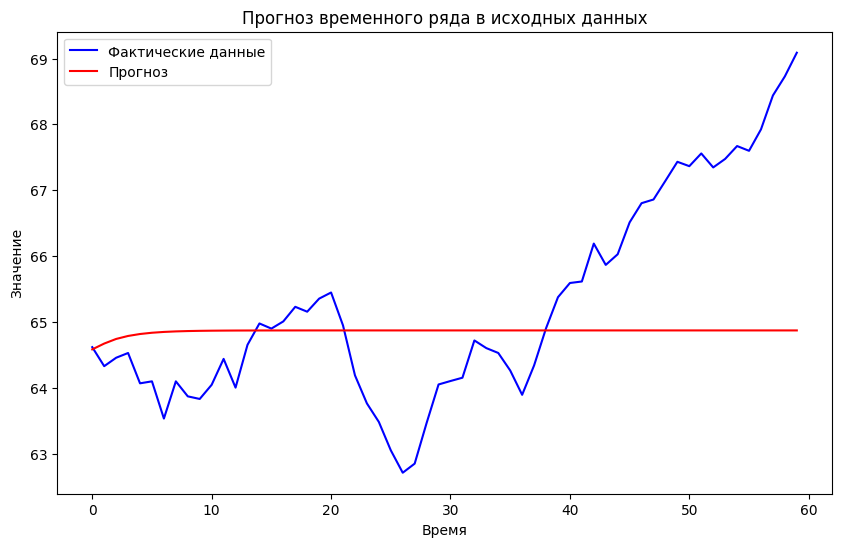

In [20]:
# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, test_data['Value'], label='Фактические данные', color='blue')
plt.plot(test_data.index, forecast_exp, label='Прогноз', color='red')
plt.legend()
plt.title('Прогноз временного ряда в исходных данных')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.show()

О многом могут сказать остатки после удаления оцененной модели. Чаше всего предполагается нормальность белого шума

Если в остатках белый шум, то значение *ACF* остатков должны лежать внутри доверительного интервала

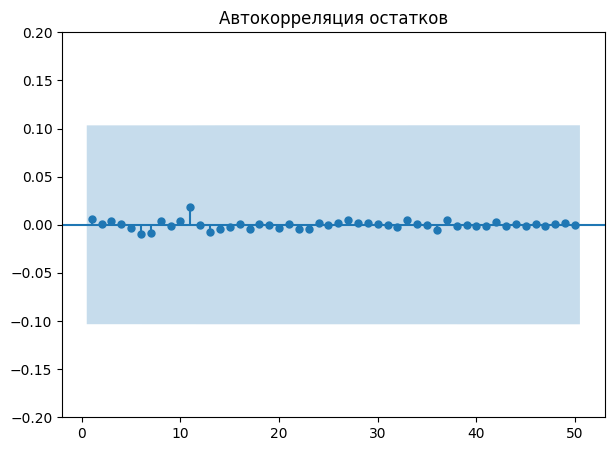

In [21]:
plt.figure(figsize=(7, 5))
plot_acf(model_1_fit.resid, lags=50, ax=plt.gca(), zero=False)
plt.ylim(-0.2, 0.2)
plt.title('Автокорреляция остатков')
plt.show()

## *ARIMA(1,1,1)*



In [22]:
model_2 = ARIMA(ts_log, order=(1, 1, 1))
model_2_fit = model_2.fit()
print(model_2_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  360
Model:                 ARIMA(1, 1, 1)   Log Likelihood                1194.582
Date:                Fri, 21 Nov 2025   AIC                          -2383.164
Time:                        17:10:45   BIC                          -2371.514
Sample:                             0   HQIC                         -2378.531
                                - 360                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5816      0.076      7.629      0.000       0.432       0.731
ma.L1         -0.1656      0.090     -1.850      0.064      -0.341       0.010
sigma2      7.531e-05   2.89e-06     26.061      0.0

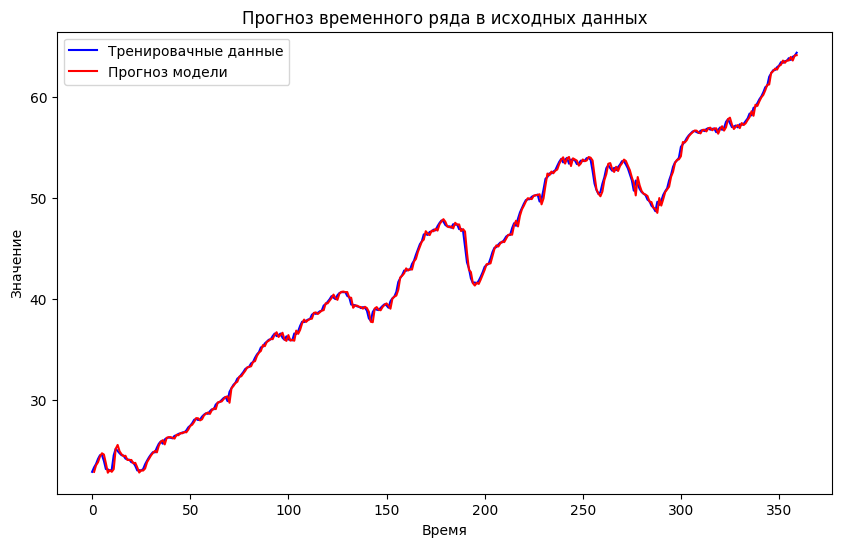

In [23]:
# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Value'], label='Тренировачные данные', color='blue')
plt.plot(data.index[1:], np.exp(model_2_fit.fittedvalues)[1:], label='Прогноз модели', color='red')
plt.legend()
plt.title('Прогноз временного ряда в исходных данных')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.show()

In [24]:
forecast = model_2_fit.forecast(steps=len(test_data))

# Преобразование прогноза в исходный масштаб
forecast_exp = np.exp(forecast)

r2 = r2_score(test_data['Value'], forecast_exp)
print(f'r2_score = {r2}')

r2_score = -0.10372836798646956


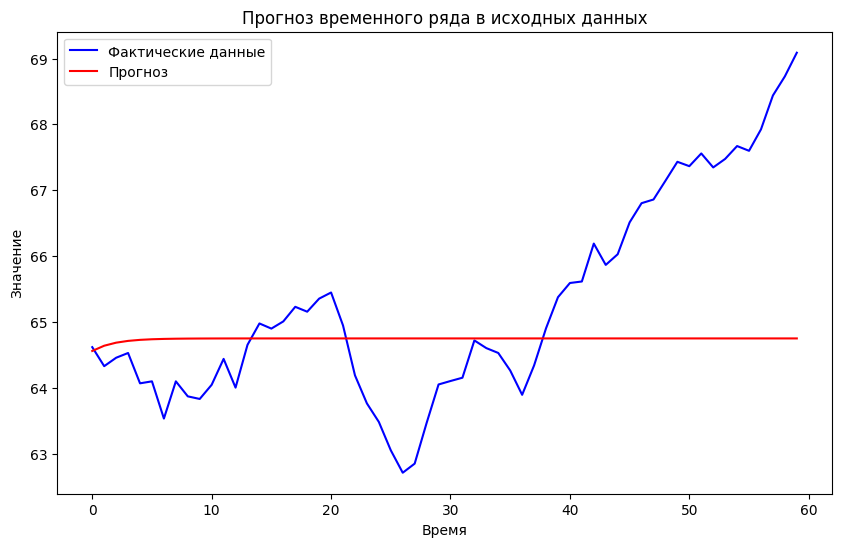

In [25]:
# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, test_data['Value'], label='Фактические данные', color='blue')
plt.plot(test_data.index, forecast_exp, label='Прогноз', color='red')
plt.legend()
plt.title('Прогноз временного ряда в исходных данных')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.show()

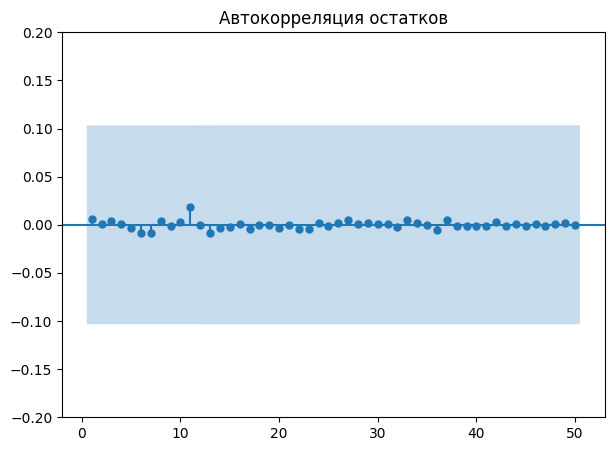

In [26]:
plt.figure(figsize=(7, 5))
plot_acf(model_2_fit.resid, lags=50, ax=plt.gca(), zero=False)
plt.ylim(-0.2, 0.2)
plt.title('Автокорреляция остатков')
plt.show()

## *ARIMA(7,1,2)*

In [27]:
model_3 = ARIMA(ts_log, order=(7, 1, 2))
model_3_fit = model_3.fit()
print(model_3_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  360
Model:                 ARIMA(7, 1, 2)   Log Likelihood                1203.933
Date:                Fri, 21 Nov 2025   AIC                          -2387.866
Time:                        17:11:37   BIC                          -2349.032
Sample:                             0   HQIC                         -2372.423
                                - 360                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3962      0.480      0.826      0.409      -0.544       1.337
ar.L2          0.2752      0.537      0.512      0.608      -0.778       1.328
ar.L3         -0.0075      0.160     -0.047      0.9

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


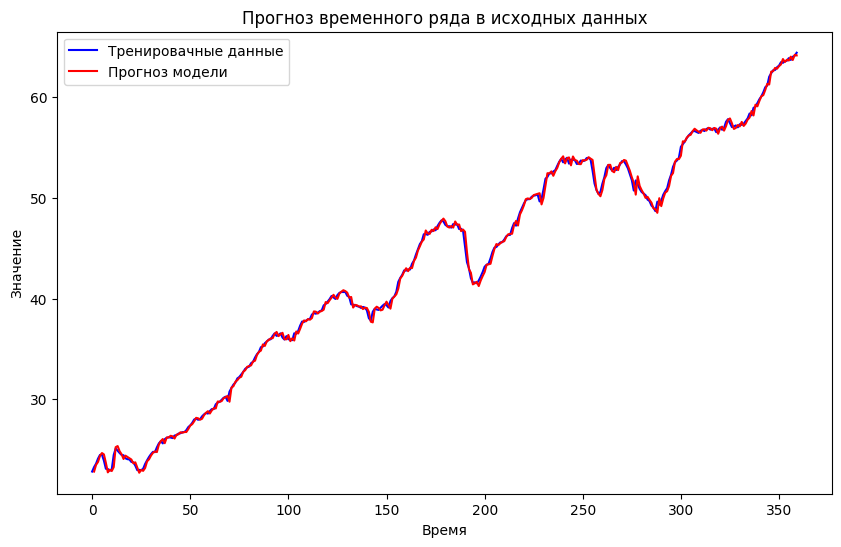

In [28]:
# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Value'], label='Тренировачные данные', color='blue')
plt.plot(data.index[1:], np.exp(model_3_fit.fittedvalues)[1:], label='Прогноз модели', color='red')
plt.legend()
plt.title('Прогноз временного ряда в исходных данных')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.show()

In [29]:
forecast = model_3_fit.forecast(steps=len(test_data))

# Преобразование прогноза в исходный масштаб
forecast_exp = np.exp(forecast)

r2 = r2_score(test_data['Value'], forecast_exp)
print(f'r2_score = {r2}')

r2_score = 0.07724233425554183


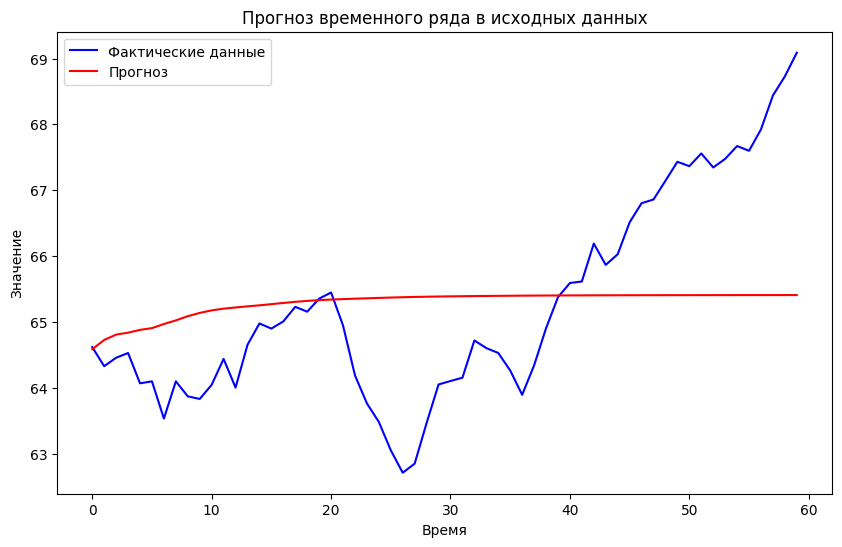

In [30]:
# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, test_data['Value'], label='Фактические данные', color='blue')
plt.plot(test_data.index, forecast_exp, label='Прогноз', color='red')
plt.legend()
plt.title('Прогноз временного ряда в исходных данных')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.show()

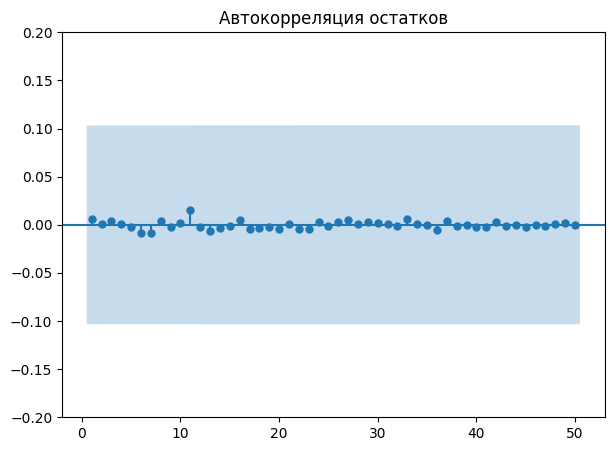

In [31]:
plt.figure(figsize=(7, 5))
plot_acf(model_3_fit.resid, lags=50, ax=plt.gca(), zero=False)
plt.ylim(-0.2, 0.2)
plt.title('Автокорреляция остатков')
plt.show()

Информационный критерий Акаике (*AIC*) — критерий, применяющийся исключительно для выбора из нескольких статистических моделей.

*AIC = 2k - 2ln(L)*,

где *k* — число параметров, *L* — значение функции правдоподобия.

Чем больше правдоподобие, тем лучше модель описывает данные. Следовательно, модель тем лучше, чем меньше значения *AIC*.


In [32]:
model_1_fit.aic

np.float64(-2381.01608242564)

In [33]:
model_2_fit.aic

np.float64(-2383.163756660337)

In [34]:
model_3_fit.aic

np.float64(-2387.8655708678234)

Видим, что наименьший *AIC* у третьей модели *ARIMA(7,1,2)*

## Вывод

С помощью моделей *ARIMA* удалось добиться *r2_score = 0.08*. Дело в том, что начиная с определенного момента модель строит константный прогноз, что плохо аппроксимирует истинную зависимость